# Forest cover type prediction in Roosevelt National Forest

# Feature engineering, selection and an stacked model

## Problem Description

In this competition you are asked to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type


### Importing the libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import gc
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
already_preprocessed=False
train_file='train.csv'
test_file='test.csv'

""" For Kaggle Kernels
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if filename==train_file:
            train_dir=dirname
        if filename==test_file:
            test_dir=dirname
"""        
# Any results you write to the current directory are saved as output.

" For Kaggle Kernels\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n        if filename==train_file:\n            train_dir=dirname\n        if filename==test_file:\n            test_dir=dirname\n"

## Loading the train and test datasets


In [2]:
#root folder
root_folder='..\..'
#data_folder='.'
data_folder_name='Datasets/RooseveltForest'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

# Both train and test set are in the data directory
train_dir = DATA_PATH
test_dir = DATA_PATH

In [3]:
# Reading the csv file with the whole dataset
data = pd.read_csv(train_dir+'/'+train_file, sep=',', header=0, index_col=0)
# Train data, delete the label column
X_train = data.drop('Cover_Type', axis=1)
# Set the label variable
y_train = data.pop('Cover_Type').astype('int8')

# Read the test data
test = pd.read_csv(test_dir+'/'+test_file, sep=',', header=0, index_col=0)

n_train=len(X_train)
print(test.shape,X_train.shape)

(565892, 54) (15120, 54)


## Feature engineering

Some kernels extract some new information, or new features, from the test data and then include that new information to the training dataset. A simple and effective aproach is to create a Gaussian Mixture model as is described for example in:
https://www.kaggle.com/stevegreenau/stacking-multiple-classifiers-clustering or in https://www.kaggle.com/arateris/2-layer-k-fold-learning-forest-cover

Lets include this new features: First we normalize the data.

In [4]:
from sklearn.preprocessing import StandardScaler
# Set a variable containing the whole dataset
all_data=X_train.append(test)
# Normalized  the data using a StandardScaler
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler().fit(all_data)
# Apply the scaler to the train and test dataset
test_scaled = scaler.transform(test)
X_train_scaled = scaler.transform(X_train)

Create a new feature using a clustering model, a Gaussian mixture model. Gaussian mixture models can be used to cluster unlabeled data in much the same way as k-means, but with teo differences: it accounts for variance and it provides us with the probability that a given data point belongs to each of the possible clusters. For a detailed explanation see: https://towardsdatascience.com/gaussian-mixture-models-d13a5e915c8e. 

Our new feature will be the cluster from the Gaussian mixture assigned to that point, the closest one. 

In [5]:
from sklearn.mixture import GaussianMixture
# Num clusters o components is a parameter to try out with 
# We apply the clustering on the test data to extrac some information from it (it is like cheating but )
gmix = GaussianMixture(n_components=10,random_state=0)
gmix.fit(test_scaled)

# Extact the cluster assigned to every point
x_train_gmix = gmix.predict(X_train_scaled)
test_gmix = gmix.predict(test_scaled)

In [6]:
# Create the new feature, including te clusters as a new feature
X_train['Cluster_Test']=x_train_gmix
test['Cluster_Test']=test_gmix

#Convert the cluster nomber to categorical (binaries columns)
X_train = pd.get_dummies(X_train,columns = ['Cluster_Test'])
test = pd.get_dummies(test,columns = ['Cluster_Test'])

print(test.shape,X_train.shape)

(565892, 64) (15120, 64)


Another way to extract a new feature is to apply principal component analysis (PCA) to create a set of "new" features. PCA is a dimension reduction technique, so we can retrive a set of variables that are a combination of the original ones and can contain non explicit information.  

In [7]:
#Apply PCA to obtain new features based in all datasets (train and test)
from sklearn.decomposition import PCA

def add_PCA_features(X):
    ''' Return the PCA components for the dataset X'''
    pca = PCA(n_components=0.99, random_state=0).fit(X)
    X_pca = pca.transform(X)
    
    return X_pca

# Extract the PCA values from the dataset
components = add_PCA_features(all_data)
# Show the dimension of the PCA components generated
print('PCA components dimension: ',components.shape)
# Create a new feature for every dimension in the PCA components
for i in range(components.shape[1]):
    col_name= 'pca'+str(i+1)
    X_train[col_name] = components[:n_train, i]
    test[col_name] = components[n_train:, i]

print(test.shape,X_train.shape)

PCA components dimension:  (581012, 4)
(565892, 68) (15120, 68)


There are four components in our PCA analysis and they are inserted as new features in our dataset. Later we will apply some techniques to remove features to avoid using correlated and non relevant features.

Now we will apply some feature engineering techniques to extract a more relevant group of features, especially Feature Crossing. Feature crossing combine multiple variables together, multiply or square them. Sometimes combining variables together can produce predictive performance that outperforms what they could’ve done in isolation.

We are goint to generate a group of features that many others competitors have worked on and looks like they can produce a gerat result. Thanks to kwabenantim, most of the feature engineering and selection in this kernells have been extracted from his excellent kernell https://www.kaggle.com/kwabenantim/forest-cover-stacking-multiple-classifiers. I strongllly recomend to read carefully and study it, not all the steps in that kernell are included in this one. This one is simpler and very easy to understand.

In [8]:
# This new features has been extracted from the kernel previously citated:
# https://www.kaggle.com/kwabenantim/forest-cover-stacking-multiple-classifiers

# Generate a group of new features, feature crossing
def add_features(X_):
    ''' Apply some feature engineering on the X_ dataset, returning the dataset with the resulting features'''
    X = X_.copy()
    # Add new features
    X['Hydro_Elevation_diff'] = (X['Elevation'] - 
                             X['Vertical_Distance_To_Hydrology'])

    X['Hydro_Fire_sum'] = (X['Horizontal_Distance_To_Hydrology'] + 
                       X['Horizontal_Distance_To_Fire_Points'])

    X['Hydro_Fire_diff'] = (X['Horizontal_Distance_To_Hydrology'] - 
                        X['Horizontal_Distance_To_Fire_Points']).abs()

    X['Hydro_Road_sum'] = (X['Horizontal_Distance_To_Hydrology'] +
                       X['Horizontal_Distance_To_Roadways'])

    X['Hydro_Road_diff'] = (X['Horizontal_Distance_To_Hydrology'] -
                        X['Horizontal_Distance_To_Roadways']).abs()

    X['Road_Fire_sum'] = (X['Horizontal_Distance_To_Roadways'] + 
                      X['Horizontal_Distance_To_Fire_Points'])

    X['Road_Fire_diff'] = (X['Horizontal_Distance_To_Roadways'] - 
                       X['Horizontal_Distance_To_Fire_Points']).abs()
    # Compute Soil_Type number from Soil_Type binary columns
    X['Soil_Type'] = sum(i * X['Soil_Type{}'.format(i)] for i in range(1, 41))

    soil_count = X['Soil_Type'].value_counts().to_dict()
    X['Soil_count'] = X['Soil_Type'].map(soil_count)

    soil_elevation = X.groupby('Soil_Type')['Elevation'].median().to_dict()
    X['Soil_Elevation'] = X['Soil_Type'].map(soil_elevation)

    # Drop features not useful for classification
    drop_cols = ['Aspect', 'Slope',  'Hillshade_3pm', 'Soil_Type']
    drop_cols += ['Soil_Type{}'.format(i) for i in range(1, 41)]
    drop_cols = [col for col in drop_cols if col in X.columns]

    X = X.drop(drop_cols, axis='columns')
    return X

In [9]:
# Add the new features to the dataset
X_train = add_features(X_train)
test = add_features(test)

print(test.shape,X_train.shape)


(565892, 34) (15120, 34)


## Feature Selection

After including a new set of features, we need to select the best combination of features that can predict the target variable. This process is called feature selection and it based on three criteria:
- Reduce low important features: The importance of a feature can be calculated using a decision tree model, random forest or gradient boosting machine learning model (GBM). You may remove less important features because they are not important for a ml model to make predictions.
- Single unique value features: Here we remove columns that have a single unique value throughout the entire dataset because a machine learning model can’t draw any conclusion out of these columns
- Colinear featurs: Collinear features are the features that are highly dependent on another feature. Due to high variance and less model interpretability, collinear features lead to decreased generalized performance. The level of correlation is identified based on a specific correlation coefficient.


In [10]:
# Plot the feature importance determined by the classifier clf
def feature_importances(clf, X, y):
    clf = clf.fit(X, y)
    
    importances = pd.DataFrame({'Features': X.columns, 
                                'Importances': clf.feature_importances_})
    
    importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

    fig = plt.figure(figsize=(14, 4))
    sns.barplot(x='Features', y='Importances', data=importances)
    plt.xticks(rotation='vertical')
    plt.show()
    
# Calculate the accuracy using a cross validated approach 
def cv_accuracy(clf, X, y):
    scores = cross_val_score(clf, X, y, 
                             cv=5, 
                             scoring='accuracy',
                             verbose=0, 
                             n_jobs=-1)
    
    print('Cross-validation accuracy: {:.3f} {}'.format(np.mean(scores),  
                                                        np.around(scores, 3)))

# Shows the confusion matrix using criss validated predictions
def cv_confusion(clf, X, y):
    prediction = cross_val_predict(clf, X, y, 
                                   cv=5, 
                                   verbose=0, 
                                   n_jobs=-1)
    
    classes = sorted(y.unique().tolist())

    conf_mat = confusion_matrix(y, prediction)
    norm_conf_mat = np.around(conf_mat / conf_mat.sum(axis=1), 2)

    fig = plt.figure(figsize=(14, 8))

    fig.add_subplot(1, 2, 1)
    ax = sns.heatmap(norm_conf_mat, annot=True, cmap='OrRd', 
                     xticklabels=classes, yticklabels=classes)
    ax.set(xlabel='Predicted Class', ylabel='True Class', title='Normalized')


    fig.add_subplot(1, 2, 2)
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='OrRd', 
                     xticklabels=classes, yticklabels=classes)
    ax.set(xlabel='Predicted Class', ylabel='True Class', title ='Counts')

    #plt.tight_layout()
    plt.show()
    
# Plot correlations between numerical features
def plot_correlations(X, annot=False):
    numericals = [col for col in X.columns if 
                  'Soil_Type' not in col and 
                  'Wilderness_Area' not in col]

    numericals = sorted(numericals)

    # Place correlations in four bins
    corr = np.around(X[numericals].corr().abs(), 1)
    
    corr_bin = corr.copy()
    corr_bin = corr_bin.where(corr_bin > 0.30, 0.30)

    corr_bin = corr_bin.where((corr_bin <= 0.30) | 
                              (corr_bin > 0.50), 0.50)

    corr_bin = corr_bin.where((corr_bin <= 0.50) | 
                              (corr_bin > 0.70), 0.70)

    corr_bin = corr_bin.where(corr_bin <= 0.70, 1.0)
    
    if annot:
        annot = corr
        
    # Show binned correlation plot
    fig = plt.figure(figsize=(12, 12))
    sns.heatmap(corr_bin, annot=annot, linewidths=1, square=True, 
                cmap='BuPu', cbar_kws={'shrink':0.5})
    plt.title('Feature Correlations')
    plt.show()

# Drop features with mode frequency > 99% of data
# Those columns are irrelevant, they have almost just one value 
def drop_unimportant(X_):
    X = X_.copy()
    
    n_rows = X.shape[0]
    hi_freq_cols = []
    
    for col in X.columns:
        mode_frequency = 100.0 * X[col].value_counts().iat[0] / n_rows 
        
        if mode_frequency > 99.0:
            hi_freq_cols.append(col)
            
    X = X.drop(hi_freq_cols, axis='columns')
    
    return hi_freq_cols,X

def drop_correlated(X_):
    X = X_.copy()
    
    drop_cols = ['Hillshade_mean', 'Hillshade_median', 'Hillshade_max', 
                 'Hillshade_min', 'Hillshade_sum', 'Hydro_Elevation_sum',
                 'Hydro_Distance_sum', 'Hydro_Distance_diff', 'Hydro_Fire_mean', 
                 'Hydro_Fire_median', 'Hydro_Manhattan', 'Hydro_Road_Fire_mean', 
                 'Hydro_Road_Fire_median', 'Hydro_Road_mean', 'Hydro_Road_median', 
                 'Road_Fire_mean', 'Road_Fire_median']
    
    drop_cols = [col for col in drop_cols if col in X.columns]
    
    X = X.drop(drop_cols, axis='columns')
    
    return drop_cols,X


We will use a simple RandomForest classifier to analyze the features, it will be the performance baseline to analyze the importance of features in our predictor model. 

In [11]:
#This classifier is used to evaluate the performance of the features in diferent scenarios: importance, correlation and so.
clf = RandomForestClassifier(n_estimators=125,
                             min_samples_leaf=1,
                             max_depth=None,
                             verbose=0,
                             random_state=0)

Show the importance of our dataset to identify unrelevant variables.

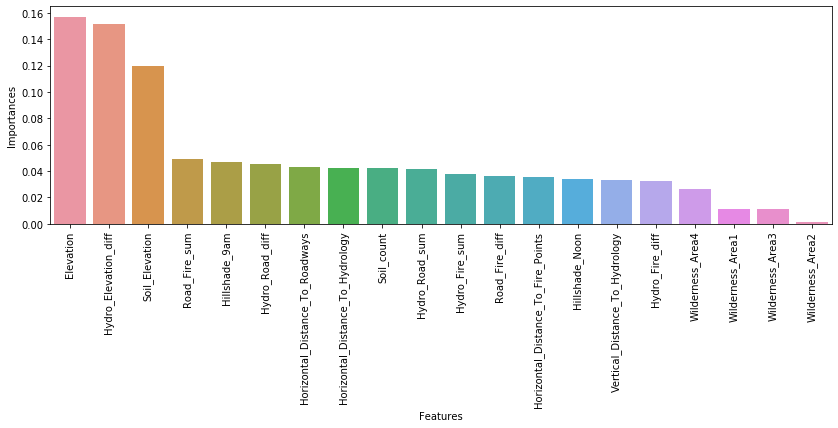

Cross-validation accuracy: 0.818 [0.808 0.78  0.792 0.821 0.886]


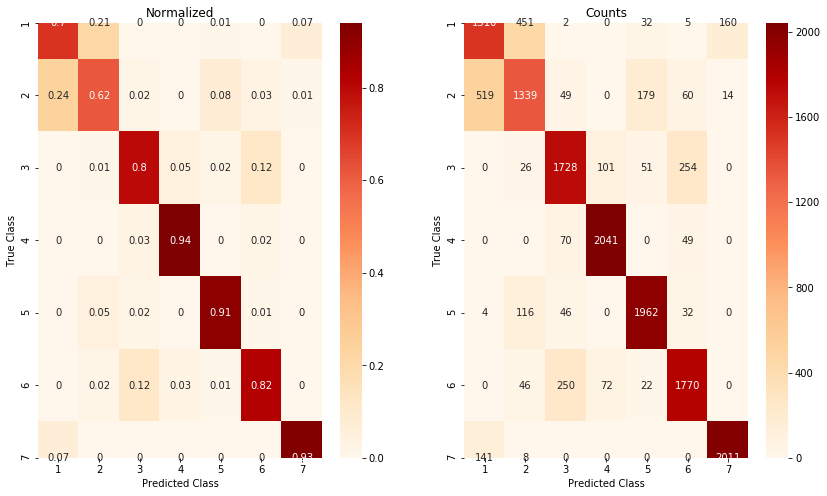

In [107]:
feature_importances(clf, X_train, y_train)
cv_accuracy(clf, X_train, y_train)
cv_confusion(clf, X_train, y_train)

We will repeat the previous analyze with our new dataset, containing the new features

Now we will drop unimportant features, those containing just a few values. Mode frequency > 99% of the data. And the last step will be to drop those correlated features.

In [12]:
# Drop umportant columns from train data
unimportant_cols,X_train = drop_unimportant(X_train)

cv_accuracy(clf, X_train, y_train)
# Drop umportant columns from test data
test = test.drop(unimportant_cols, axis='columns')
print(test.shape,X_train.shape)

Cross-validation accuracy: 0.812 [0.795 0.784 0.788 0.81  0.885]
(565892, 34) (15120, 34)


Drop correlated columns they usually do not provide information for a better classifier but they can overfit out model

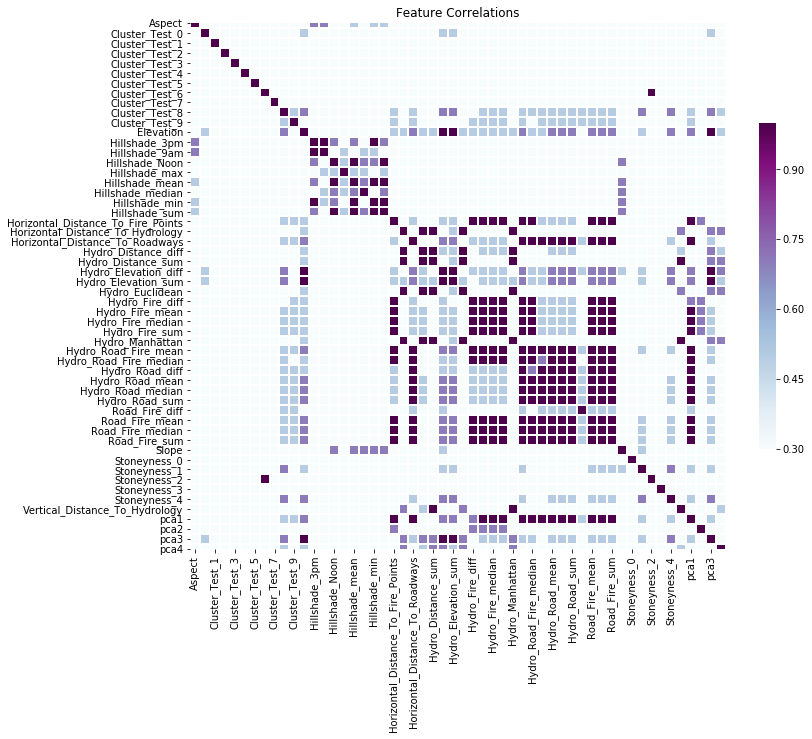

(565892, 64) (15120, 64)


In [20]:
plot_correlations(X_train, annot=False)
#Drop correlated columns from test data
dropped_cols, X_train = drop_correlated(X_train)
#Drop correlated columns from test data
test = test.drop(dropped_cols, axis='columns')
print(test.shape,X_train.shape)

Evaluate the final dataset after removing some unrelevant features in the previous steps

(565892, 34) (15120, 34)
Cross-validation accuracy: 0.812 [0.795 0.784 0.788 0.81  0.885]


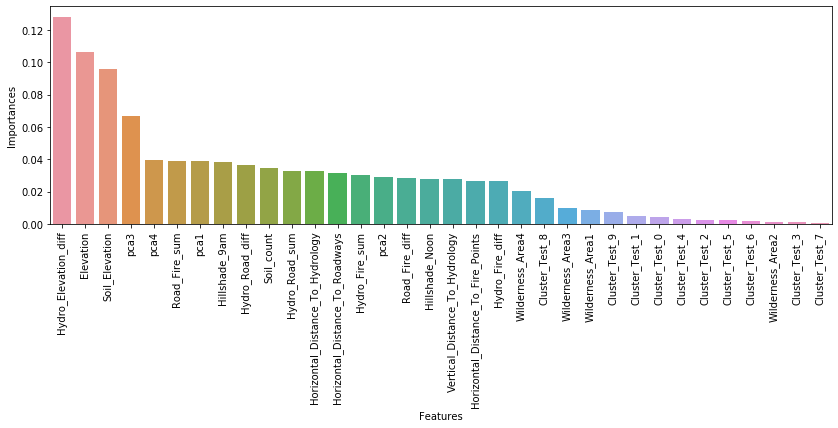

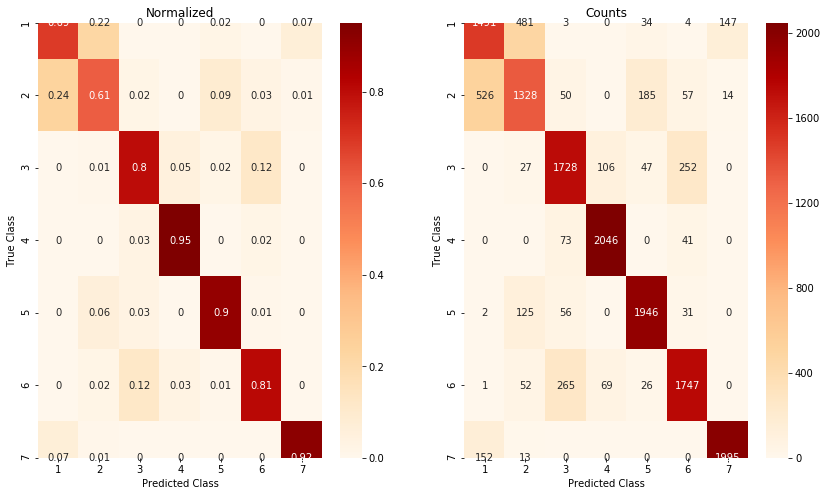

In [13]:
#Lets evaluate our final dataset
print(test.shape,X_train.shape)

cv_accuracy(clf, X_train, y_train)
feature_importances(clf, X_train, y_train)
cv_confusion(clf, X_train, y_train)

Lets save the final train and test dataset to be use in the classifiers

In [14]:
df1 = X_train.assign(Cover_Type=y_train)
df1.to_csv('train_fe.csv', sep=',', header=True, index=True, index_label='Id')
test.to_csv('test_fe.csv', sep=',', header=True, index=True, index_label='Id')

### Preparing the data for a machine learning model

Now we will scale the data

In [15]:
from sklearn.preprocessing import MinMaxScaler

all_data=X_train.append(test)
# Define a normalization tranformer
scaler=MinMaxScaler((0, 100)).fit(all_data)

# Normalize the datasets
X_train.loc[:, :] = np.floor(scaler.transform(X_train))
X_train = X_train.astype('int8')

test.loc[:, :] = np.floor(scaler.transform(test))
test = test.astype('int8')


In [16]:
# Tranform the dataframe to numpy arrays
X = X_train.values
y = y_train.values
test_ds= test.values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

print('X: ', X.shape)
print('y: ', y.shape)
print('test: ', test_ds.shape)

X:  (15120, 34)
y:  (15120,)
test:  (565892, 34)


## Ensemble Stacked Model
Ensemble modeling is now a well-established means for improving prediction accuracy; it enables you to average out noise from diverse models and thereby enhance the generalizable signal. Basic stacked ensemble techniques combine predictions from multiple machine learning algorithms and use these predictions as inputs to second-level learning models. It involves combining the predictions from multiple machine learning models on the same dataset, like bagging and boosting.

The architecture of a stacking model involves two or more base models, often referred to as level-0 models, and a meta-model that combines the predictions of the base models, referred to as a level-1 model.

- Level-0 Models (Base-Models): Models fit on the training data and whose predictions are compiled.
- Level-1 Model (Meta-Model): Model that learns how to best combine the predictions of the base models.

### Classifiers in the Level 0 of the stacked model

Create a dictionary with the diferents models in the Level 1 in the stacked model. There are many posibilities, I have tested some of them using GridSearchCV for some parameter tunning (but they can be improved with some other experiments). You can check some great kernels published by others members:

https://www.kaggle.com/stevegreenau/stacking-multiple-classifiers-clustering
https://www.kaggle.com/phsheth/forestml-part-6-stacking-selfets-gmix-smote

Bayesian optimization for hyperparameters. ¿Try?
https://www.kdnuggets.com/2019/07/xgboost-random-forest-bayesian-optimisation.html


In [17]:
#Define a ratio for every class weighted
#ratio_weight={1:0.3, 2:0.3, 3: 0.1, 4:0.05, 5:0.1, 6:0.1, 7:0.05}
max_features = min(30, X_train.columns.size)

In [18]:
#Estimators: 400, 400, 400, 125 (reduce to 100 100 100 100 for some tests)
# Create a dictionary with the different models we can apply, some of them will be commented 
# to avoid using them on the stacke model
models = {
    'Random Forest': RandomForestClassifier(criterion = 'gini',n_estimators=400, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                    max_leaf_nodes=None,random_state = 0, class_weight = None),
    'AdaBoost': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion = 'gini', max_depth=None, min_samples_split=2,
                                                                         min_samples_leaf=1,max_leaf_nodes=None,
                                                                         random_state = 0, class_weight = None),
                                   n_estimators=300,learning_rate=0.2,random_state=0),
    
    #'Bagging': BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion = 'entropy', max_depth=None, min_samples_split=2,
    #                                                                     min_samples_leaf=1,max_leaf_nodes=None,max_features='auto',
    #                                                                     random_state = 0),
    #                               n_estimators=300,max_features=0.75, max_samples=1.0, random_state=0,n_jobs=-1,verbose=0),
    #{'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 300}
    #'GBM': GradientBoostingClassifier(n_estimators=500, learning_rate= 0.2, max_depth=10, min_samples_leaf=1, 
    #                                  min_samples_split=2,random_state=0,verbose=1),
    'LGBM': LGBMClassifier(n_estimators=300, num_leaves=128, learning_rate= 0.1, objective= 'multiclass', num_class=7, 
                           random_state= 0, n_jobs=-1, class_weight = None),
    #'LGBM': LGBMClassifier(n_estimators=300, num_leaves=100, verbosity=0, random_state=0,n_jobs=-1),
    #'KNN': KNeighborsClassifier(n_neighbors=7, n_jobs=-1),
    # 'XGB': XGBClassifier(n_estimator= 200, learning_rate= 0.1, max_depth= 50, objective= 'binary:logistic',random_state= 0,n_jobs=-1),
    'Extra Tree': ExtraTreesClassifier(criterion = 'gini', n_estimators=300, max_depth=50, min_samples_split=2,min_samples_leaf=2, 
                                      max_leaf_nodes=None,oob_score=False, warm_start=True, random_state = 0, 
                                      max_features=max_features, class_weight = None)
}

Lets evaluate our level-0 classifiers using cross validation, splits = 5

In [19]:
from sklearn.model_selection import KFold, cross_val_score

# Create the splits for cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=0)

In [121]:
# Evaluate the L0 classifiers. This step is only necessary when experimenting with different combination of models, 
# but when we select the final models in L0 we can skip this step for training.
results= dict()
for name, model in models.items():
    print('Evaluating Model: ',name)
    cv_results = cross_val_score(model, X, y,
                                cv=cv, 
                                scoring='accuracy')
    results[name] = cv_results
    print(name, 'Accuracy Mean {0:.4f}, Std {1:.4f}'.format(
              cv_results.mean(), cv_results.std()))

accuracies= dict()
for name, accs in results.items():
    accuracies[name]=accs.mean()
    
best_model=max(accuracies, key=accuracies.get)
print('Best Model: ',best_model,' Accuracy: ',accuracies[best_model])

Evaluating Model:  Random Forest
Random Forest Accuracy Mean 0.8919, Std 0.0061
Evaluating Model:  AdaBoost
AdaBoost Accuracy Mean 0.7937, Std 0.0082
Evaluating Model:  GBM
      Iter       Train Loss   Remaining Time 
         1       13667.7726            5.22m
         2        9898.4484            7.07m
         3        7517.9394            7.55m
         4        5743.3423            7.82m
         5        4524.4453            8.02m
         6        3626.1486            8.18m
         7        2970.6414            8.29m
         8        2425.3214            8.36m
         9        2000.5692            8.43m
        10        1671.6210            8.53m
        20         448.6706            8.55m
        30         169.9908            7.91m
        40          69.1669            7.38m
        50          30.9718            6.80m
        60          15.3047            6.28m
        70           8.3592            5.72m
        80           5.5700            5.14m
        90      

## Classifier for Level 1 of the Stacked model
Now we have determined the best model and its accuracy, so the next step is to create a stacked model whose L0 classifiers are the previuos models and the meta-classifier (L1 classifier) will be the best model in the Level 0 or one determined by experimentation. Finally we will test the model using prediction probabilities in L0 and adding or not the features of te datasets, we will try out both approaches.

The outputs from the base models used as input to the meta-model may be real value in the case of regression, and probability values, probability like values, or class labels in the case of classification. The training data for the meta-model may also include the inputs to the base models, e.g. input elements of the training data. This can provide an additional context to the meta-model as to how to best combine the predictions from the meta-model.


In [20]:
#meta_model=models[best_model]
meta_model=RandomForestClassifier(criterion = 'gini',n_estimators=200, max_depth=None, min_samples_split=2, 
                                  min_samples_leaf=1, max_leaf_nodes=None,random_state = 0)
#meta_model=LGBMClassifier(n_estimators=20, learning_rate= 0.1, objective= 'multiclass', num_class=7, random_state= 0, 
#                           n_jobs=-1, class_weight = None)
#meta_model=XGBClassifier(n_estimator= 100, learning_rate= 0.1, max_depth= 50, objective= 'binary:logistic',random_state= 0,n_jobs=-1)
#meta_model=LogisticRegression(max_iter=1000, n_jobs=-1, solver= 'lbfgs',multi_class = 'multinomial')

Define a stacked model, using the meta classifier in the cell before, a Random Forest model.

In [21]:
from mlxtend.classifier import StackingCVClassifier

clfs = [m for m in models.values()]

stacked_model = StackingCVClassifier(classifiers=clfs,
                             meta_classifier=meta_model,
                             cv=cv,
                             stratify=True,
                             shuffle=True,
                             #drop_last_proba=False,
                             use_probas=True,
                             use_features_in_secondary=True,
                             verbose=1,
                             store_train_meta_features=True,
                             random_state=0,
                             n_jobs=-1)


When training and experimenting with the model we apply a cross validation strategy to score and evaluate a bunch of models. When we have chosen the best approach we can skip this step and train or fit the model.

In [39]:
#It is time for evaluating the stacked model
scores = cross_val_score(stacked_model, X, y, cv=cv, scoring='accuracy', verbose=0)

print('Accuracy: %0.4f (+/- %0.4f)' % (scores.mean(), scores.std()))

Fitting 5 classifiers...
Fitting classifier1: randomforestclassifier (1/5)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: adaboostclassifier (2/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: baggingclassifier (3/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   24.1s remaining:   36.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier4: lgbmclassifier (4/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.5s remaining:   50.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier5: extratreesclassifier (5/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.0s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


Fitting 5 classifiers...
Fitting classifier1: randomforestclassifier (1/5)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   43.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: adaboostclassifier (2/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: baggingclassifier (3/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   24.0s remaining:   36.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier4: lgbmclassifier (4/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   32.3s remaining:   48.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier5: extratreesclassifier (5/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.0s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 classifiers...
Fitting classifier1: randomforestclassifier (1/5)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   42.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: adaboostclassifier (2/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: baggingclassifier (3/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   24.1s remaining:   36.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier4: lgbmclassifier (4/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.5s remaining:   47.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier5: extratreesclassifier (5/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


Fitting 5 classifiers...
Fitting classifier1: randomforestclassifier (1/5)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.2s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: adaboostclassifier (2/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: baggingclassifier (3/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.6s remaining:   35.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier4: lgbmclassifier (4/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   32.0s remaining:   48.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier5: extratreesclassifier (5/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 classifiers...
Fitting classifier1: randomforestclassifier (1/5)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.2s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: adaboostclassifier (2/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: baggingclassifier (3/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.3s remaining:   35.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier4: lgbmclassifier (4/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   30.0s remaining:   45.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier5: extratreesclassifier (5/5)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.1s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


Accuracy: 0.9034 (+/- 0.0079)


In [22]:
stacked_model

StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap=True,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimators=400,
                                                         n_jobs=

Finally we will fit or train our model and then we predict on the training and test data to get the final results 

In [22]:
# Fit and predict the stacked model on both train and test data
stacked_model.fit(X, y)
predictions = stacked_model.predict(X)
predictions_test = stacked_model.predict(test_ds)
print('Stacked Model Accuracy: ',round(accuracy_score(y, predictions),4))

Fitting 4 classifiers...
Fitting classifier1: randomforestclassifier (1/4)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.1s remaining:   25.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: adaboostclassifier (2/4)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: lgbmclassifier (3/4)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier4: extratreesclassifier (4/4)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.1s remaining:   46.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished


Stacked Model Accuracy:  0.9999


In [117]:
# Show the classifiers used in the training stage
stacked_model.named_classifiers

[('randomforestclassifier',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=400,
                         n_jobs=None, oob_score=False, random_state=0, verbose=0,
                         warm_start=False)),
 ('adaboostclassifier', AdaBoostClassifier(algorithm='SAMME.R',
                     base_estimator=DecisionTreeClassifier(class_weight=None,
                                                           criterion='gini',
                                                           max_depth=None,
                                                           max_features=None,
                                                           max_leaf_nodes=None,
                

Save the input meta-features to L1 classifier, it can be used in another kind of model as a NN

In [23]:
df= pd.DataFrame(data=stacked_model.train_meta_features_, index=X_train.index.values)
df.to_csv("meta_features_L2_train.csv", index=True)

In [24]:
# We need to create the meta features for the test dataset
metaf_test = stacked_model.predict_meta_features(test_ds)

In [25]:
#metaf.shape
#stacked_model.meta-features
df= pd.DataFrame(data=metaf_test, index=test.index.values)
df.to_csv("meta_features_L2_test.csv", index=True)

### Generate a submission file with the predictions

Create the submission file with the predictions for the test dataset and then we upload the file to Kaggle.

In [26]:
submission = pd.DataFrame({ 'Id': test.index.values,
                            'Cover_Type': predictions_test })
submission.to_csv("submission_data.csv", index=False)

Submit the predictions to Kaggle

In [2]:
!kaggle  competitions  submit -c learn-together -f roosevelt_Submit20191028184319.csv -m "New FE Clus-dum PCA ScaleAll no corr L1:RF Ada LGBM ET L2:Tabular 3layembsz"

Successfully submitted to Learn With Other Kaggle Users



  0%|          | 0.00/4.78M [00:00<?, ?B/s]
  0%|          | 8.00k/4.78M [00:00<01:38, 50.9kB/s]
  5%|4         | 232k/4.78M [00:00<01:06, 71.9kB/s] 
 18%|#7        | 856k/4.78M [00:00<00:40, 102kB/s] 
 37%|###7      | 1.79M/4.78M [00:00<00:21, 145kB/s]
 52%|#####1    | 2.46M/4.78M [00:01<00:12, 191kB/s]
 58%|#####7    | 2.75M/4.78M [00:01<00:08, 262kB/s]
 76%|#######6  | 3.64M/4.78M [00:01<00:03, 369kB/s]
 85%|########4 | 4.05M/4.78M [00:01<00:01, 500kB/s]
 93%|#########2| 4.43M/4.78M [00:02<00:00, 674kB/s]
100%|##########| 4.78M/4.78M [00:04<00:00, 1.22MB/s]


In [3]:
!kaggle competitions submissions -c learn-together -q

fileName                                 date                 description                                                                  status    publicScore  privateScore  
---------------------------------------  -------------------  ---------------------------------------------------------------------------  --------  -----------  ------------  
roosevelt_Submit20191028184319.csv       2019-10-28 19:10:56  New FE Clus-dum PCA ScaleAll no corr L1:RF Ada LGBM ET L2:Tabular 3layembsz  complete  0.34040      None          
submission_data.csv                      2019-10-28 16:13:29  New FE Clus-dum PCA ScaleAll no corr L1:RF Ada LGBM ET L2:RF                 complete  0.81862      None          
submission_data.csv                      2019-10-21 17:43:28  New FE Scale no corr L1:RF Ada LGBM ET L2:RF                                 complete  0.80936      None          
submission_data.csv                      2019-10-21 17:29:19  New FE Scale no corr L1:RF Ada LGBM ET L2:RF         